In [36]:
# Nguyen Hai Duong
# nhduong_3010@live.com
# Chonnam National University
# 2018.01.30

# Overview
- ModelCheckpoint: save model while training
- EarlyStopping: stop training early to avoid overfitting
- ReduceLROnPlateau: reduce learning rate while training
- TensorBoard: plot training and validation metrics

# Import libraries

In [5]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# Training utilities
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_classes = 2   # male vs. female

# (1) Data

### Download data at https://drive.google.com/open?id=0BxINLo5jshCRYW8xODhNSlkyLTQ
This source code and npy files MUST be in the same location

In [4]:
x_train = np.load('64_64_11938_4098_train_x_onehot.npy')
y_train = np.load('64_64_11938_4098_train_y_onehot.npy')
x_train = np.rot90(x_train, k=3, axes=(1, 2))

x_test = np.load('64_64_5968_4098_val_x_onehot.npy')
y_test = np.load('64_64_5968_4098_val_y_onehot.npy')
x_test = np.rot90(x_test, k=3, axes=(1, 2))

# (2) Declare model

In [6]:
# 64x64 portray image
input_image = Input(shape=(64, 64, 1), name='Input')

# conv, pooling layers + dropout
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_1')(input_image)
x = Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu', name='conv1_2')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
x = Dropout(rate=0.2, name='conv_dropout1')(x)

x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_2')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv2_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
x = Dropout(rate=0.2, name='conv_dropout2')(x)

x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_1')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_2')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv3_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
x = Dropout(rate=0.2, name='conv_dropout3')(x)

x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_1')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_2')(x)
x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv4_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
x = Dropout(rate=0.2, name='conv_dropout4')(x)

x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_1')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_2')(x)
x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv5_3')(x)
x = MaxPooling2D(pool_size=(2, 2), name='pool5')(x)
x = Dropout(rate=0.2, name='conv_dropout5')(x)

# similar to the MLP example!
# matrix ---> vector
x = Flatten(name='flatten')(x)

# FC layers + dropout
x = Dense(units=1024, activation='relu', name='fc1')(x)
x = Dropout(rate=0.2, name='fc_dropout1')(x)

x = Dense(units=1024, activation='relu', name='fc2')(x)
x = Dropout(rate=0.2, name='fc_dropout2')(x)

output_label = Dense(units=num_classes, activation='softmax', name='fc3_10ways_softmax')(x)

# define model
model = Model(inputs=input_image, outputs=output_label, name='mnist_mlp')

# print model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 64, 64, 16)        160       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 64, 64, 16)        2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv_dropout1 (Dropout)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2_2 (Conv2D)             (None, 32, 32, 32)        9248      
__________

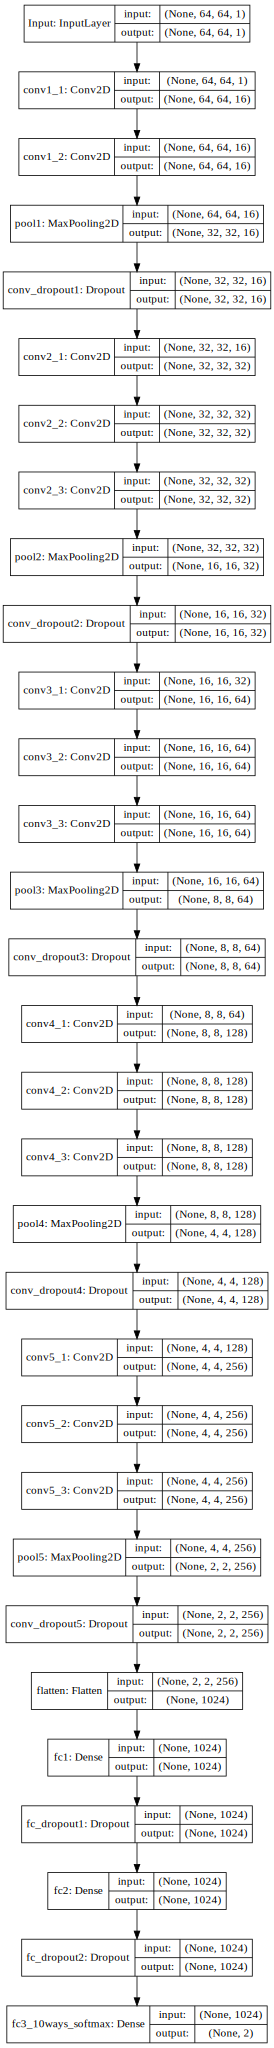

In [7]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# (3) Train defined model
- Note that the training history including loss and accuracy will be save in 'history' variable
- In case your system runs out of memory (OOM), try to decrease batch size

In [10]:
# declare learning rate, loss function, and model metric
loss = 'categorical_crossentropy'
lr = 0.001
model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=['accuracy'])

# train the model
batch_size = 128
epochs = 100000 # Since we are going to use EarlyStopping, the number of epochs should be as large as possible!

# ===============================
#      Training utilities
# ===============================
# ModelCheckpoint: save model while training
check_pointer = ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath='{epoch:06d}-{loss:.4f}-{acc:.4f}-{val_loss:.4f}-{val_acc:.4f}.hdf5')

# EarlyStopping: stop training early to avoid overfitting
early_stopping_after_epochs = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_after_epochs)

# ReduceLROnPlateau: reduce learning rate while training (new_lr = lr x factor)
reduce_lr_after_epochs = 5
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=reduce_lr_after_epochs, min_lr=0.0001)

# TensorBoard: plot training and validation metrics
tf_board = TensorBoard(log_dir='./logs')
# Open cmd, run tensorboard --logdir=./logs then follow the instruction

starting_time = time.time()
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=[check_pointer, early_stopping, reduce_lr, tf_board])

print('> training time is %.4f minutes' % ((time.time() - starting_time)/60))

Train on 11938 samples, validate on 5968 samples
Epoch 1/100000
11938/11938 [==============================] - 7s 565us/step - loss: 0.5144 - acc: 0.7885 - val_loss: 0.5109 - val_acc: 0.7885
Epoch 2/100000
11938/11938 [==============================] - 6s 490us/step - loss: 0.5135 - acc: 0.7884 - val_loss: 0.4939 - val_acc: 0.7885
Epoch 3/100000
11938/11938 [==============================] - 6s 484us/step - loss: 0.4884 - acc: 0.7883 - val_loss: 0.4848 - val_acc: 0.7885
Epoch 4/100000
11938/11938 [==============================] - 6s 484us/step - loss: 0.4726 - acc: 0.7944 - val_loss: 0.4625 - val_acc: 0.8070
Epoch 5/100000
11938/11938 [==============================] - 6s 485us/step - loss: 0.4600 - acc: 0.8041 - val_loss: 0.4536 - val_acc: 0.8095
Epoch 6/100000
11938/11938 [==============================] - 6s 491us/step - loss: 0.4513 - acc: 0.8099 - val_loss: 0.4378 - val_acc: 0.8200
Epoch 7/100000
11938/11938 [==============================] - 6s 486us/step - loss: 0.4418 - acc: 0

### Training time
- Training time with GTX 1080 is about 3.1879 minutes for 32 epochs
- Validation accuracy is ~87.7% at epoch #27. Without training utilities, the best accuracy should be ~82.6%

### Load trained model and evaluate it again with validation set

In [13]:
model.load_weights('000027-0.2789-0.8976-0.3237-0.8773.hdf5')
model.evaluate(x_test, y_test)

5968/5968 [==============================] - 1s 233us/step


[0.3237280320306246, 0.8773458445040214]

### Checkpoint files

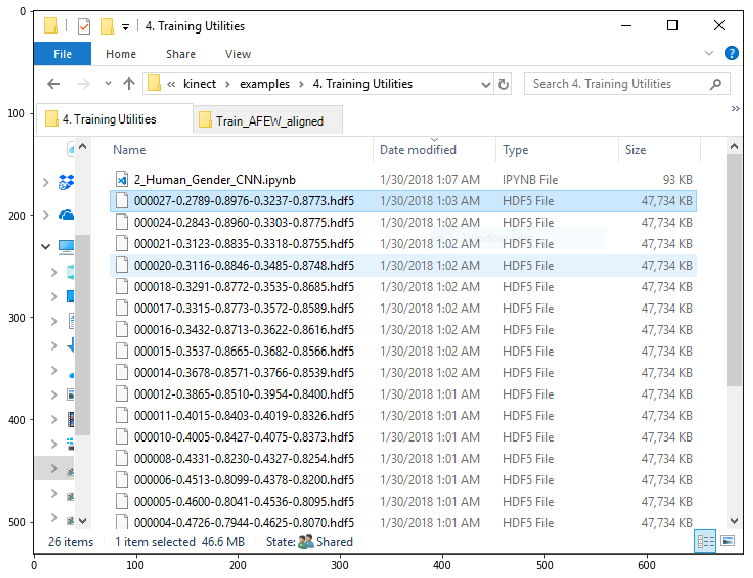

In [26]:
cp = plt.imread('checkpoints.PNG')
plt.figure(figsize=(15, 10))
plt.imshow(cp)
plt.show()

### TensorBoard

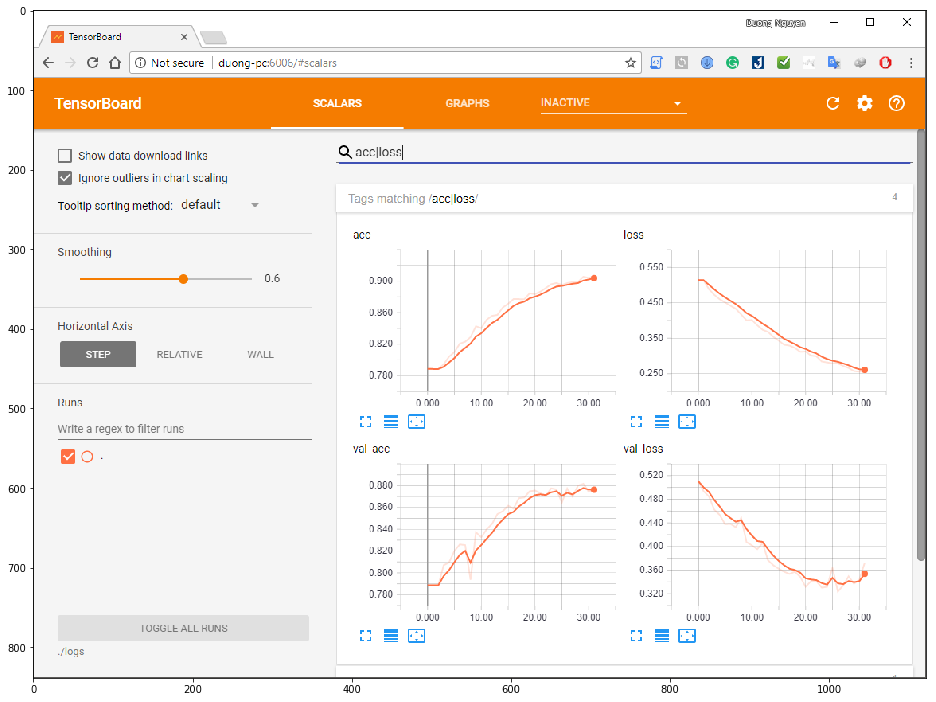

In [35]:
cp = plt.imread('tfboard.PNG')
plt.figure(figsize=(16, 13))
plt.imshow(cp)
plt.show()

# (4) Evaluate trained model

In [14]:
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

5968/5968 [==============================] - 1s 226us/step
Test loss: 0.3237280320306246
Test accuracy: 0.8773458445040214


In [15]:
def int2gender(num):
    if num == 0:
        return 'female'
    else:
        return 'male'

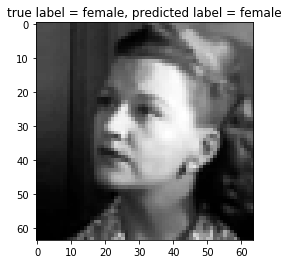

In [16]:
# select a test image randomly
random_test_index = np.random.choice(x_test.shape[0], size=1)[0]
test_img = x_test[random_test_index]
test_label = np.argmax(y_test[random_test_index])

# predict test image with trained model
pred_label = model.predict(np.expand_dims(test_img, axis=0))
pred_label = np.argmax(pred_label)

plt.imshow(test_img[:, :, 0], cmap='gray')
plt.title('true label = %s, predicted label = %s' % (int2gender(test_label), int2gender(pred_label)))
plt.show()